In [1]:
import numpy as np
import awkward as ak
import fastjet
import uproot as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt
import math
import matplotlib as colors
import matplotlib as abc
from scipy.optimize import curve_fit
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
from scipy.interpolate import UnivariateSpline

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
lowerRange = 20
upperRange = 70
width = 5
generator = "P8H"
scale = "P8H"
with open('JetDFs/{}Reco.pickle'.format(generator), 'rb') as handle:
    reco_dict_test = pickle.load(handle)
with open('JetDFs/{}Gen.pickle'.format(generator), 'rb') as handle:
    gen_dict_test = pickle.load(handle)
with open('Scale2D_{}.pickle'.format(scale), 'rb') as f:
    EtaSlice, AvgEReco, AvgERecoErr, AvgR, AvgRErr = pickle.load(f)
EtaWidth = np.array(list(set(EtaSlice)))[1] - np.array(list(set(EtaSlice)))[0]

In [3]:
def custom_spline(x):
    if isinstance(x, (list, np.ndarray)):
        return np.array([custom_spline(xi) for xi in x])
    if x <= np.array(AvgEReco)[mask][-1] and x >= np.array(AvgEReco)[mask][0]:
        return spl(x)
    elif x >= np.array(AvgEReco)[mask][-1]:
        return np.array(AvgR)[mask][-1]
    else:
        return np.array(AvgR)[mask][0]      

In [4]:
print(len(reco_dict_test["energy"]))

5000000


In [5]:
mask = (ak.flatten(reco_dict_test["matched_index_new"]) > -1)
matchedJetEtest = ak.flatten(reco_dict_test["energy"])[mask]
matchedJetEtatest = ak.flatten(reco_dict_test["eta"])[mask]
matchedJetPhitest = ak.flatten(reco_dict_test["phi"])[mask]

mask = ak.flatten(gen_dict_test["matched_index_new"]) > -1
matchedGjetEtest = ak.flatten(gen_dict_test["energy"])[mask]
matchedGjetEtatest = ak.flatten(gen_dict_test["eta"])[mask]
matchedGjetPhitest = ak.flatten(gen_dict_test["phi"])[mask]

mask = ak.flatten(reco_dict_test["matched_index_new"]) == -1
unmatchedJetEtest = ak.flatten(reco_dict_test["energy"])[mask]
unmatchedJetEtatest = ak.flatten(reco_dict_test["eta"])[mask]
unmatchedJetPhitest = ak.flatten(reco_dict_test["phi"])[mask]

mask = ak.flatten(gen_dict_test["matched_index_new"]) == -1
unmatchedGjetEtest = ak.flatten(gen_dict_test["energy"])[mask]
unmatchedGjetEtatest = ak.flatten(gen_dict_test["eta"])[mask]
unmatchedGjetPhitest = ak.flatten(gen_dict_test["phi"])[mask]

allRecoE = ak.flatten(reco_dict_test["energy"])

In [6]:
PairedGenEtest = matchedGjetEtest
PairedRecoEtest = matchedJetEtest
JetRtest = PairedRecoEtest/PairedGenEtest

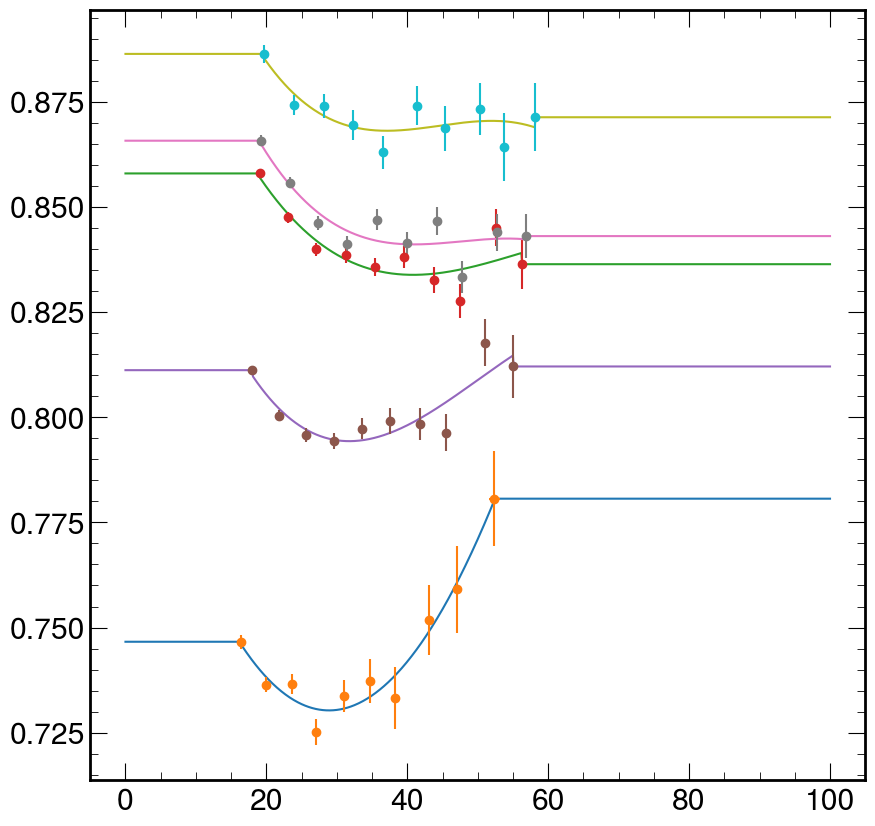

In [7]:
correctedReco = []
correctedGE = []
JetRC = []
for i in set(EtaSlice):
    etaMask = (matchedJetEtatest > (i - (EtaWidth/2))) & (matchedJetEtatest < (i + (EtaWidth/2)))
    maskedE = matchedJetEtest[etaMask]
    correctedGE.append(matchedGjetEtest[etaMask])
    mask = (np.array(EtaSlice) == i)
    spl = UnivariateSpline(np.array(AvgEReco)[mask], np.array(AvgR)[mask], k=3, s=0.1)
    xnew = np.linspace(0, 100, num=1001)
    plt.plot(xnew,custom_spline(xnew))
    plt.errorbar(np.array(AvgEReco)[mask],np.array(AvgR)[mask],xerr=np.array(AvgERecoErr)[mask],yerr=np.array(AvgRErr)[mask],fmt="o",label="Eta %2.2f - %2.2f"%(i-(EtaWidth/2), i + (EtaWidth/2)))
    correctedReco.append(maskedE / custom_spline(np.array(maskedE)))
    JetRC.append((maskedE / custom_spline(np.array(maskedE))) / matchedGjetEtest[etaMask])




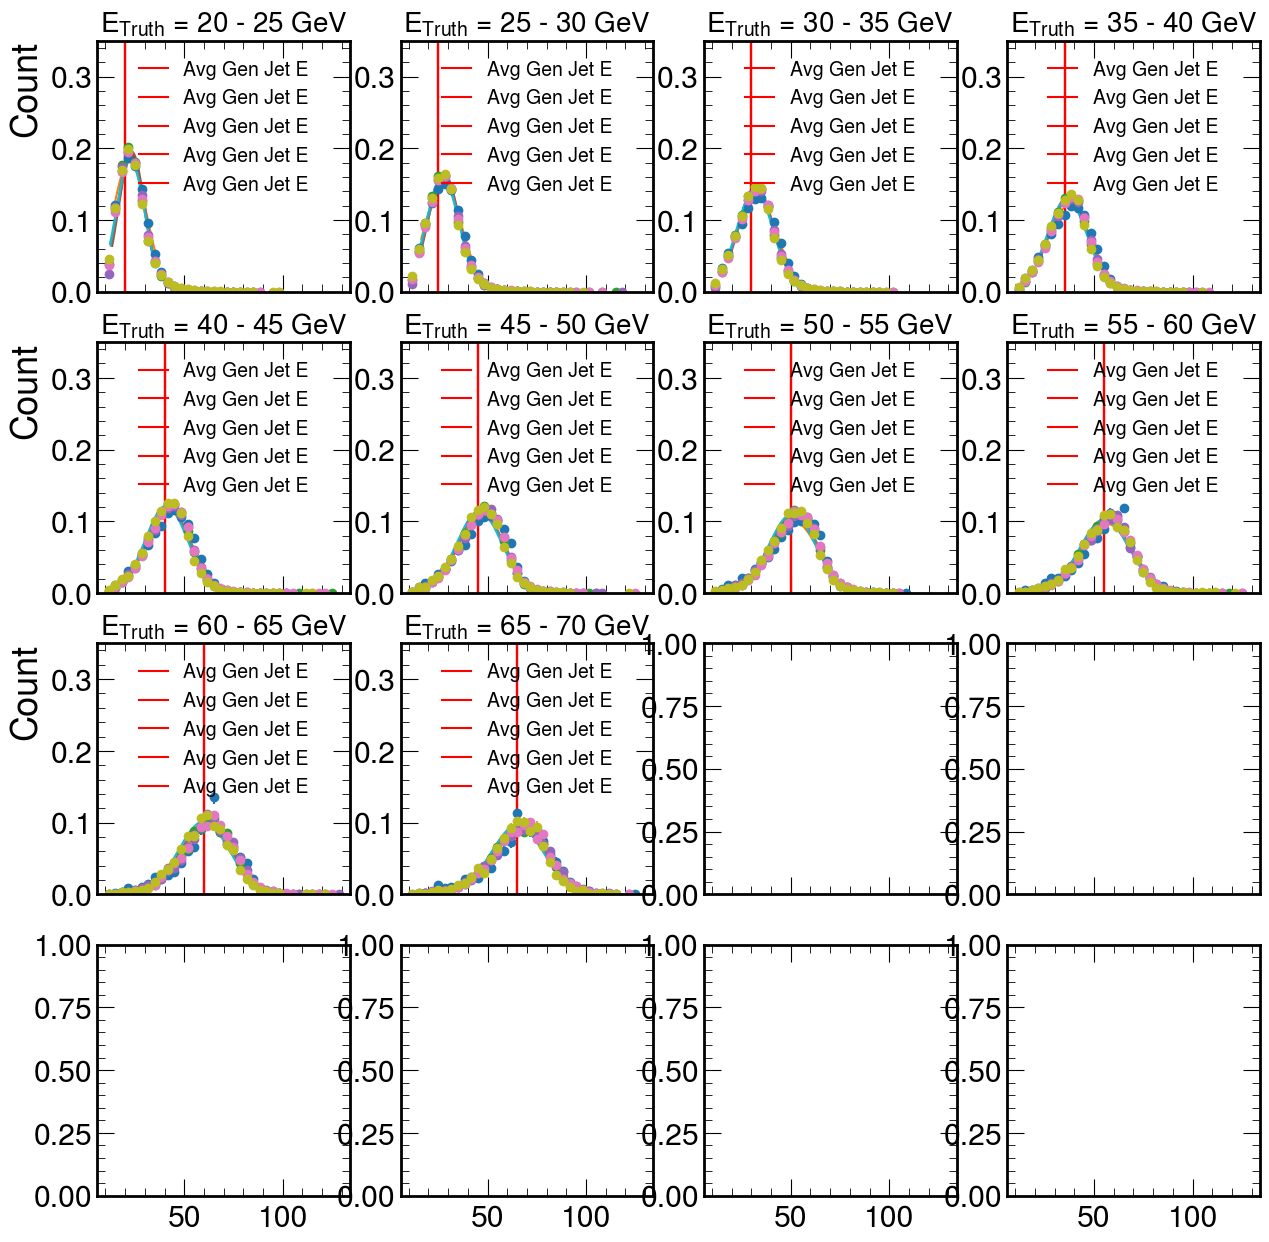

In [8]:
fig, axs=plt.subplots(4, 4, figsize=(15,15),sharex=True)
#fig.subplots_adjust(wspace=0.4, hspace=0)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
EtaCAvgEReco = []
EtaCAvgERecoErr = []

EtaCNumEReco = []
EtaCNumERecoErr = []

for eta in range(len(correctedGE)):
    CAvgEReco = []
    CAvgERecoErr = []

    CNumEReco = []
    CNumERecoErr = []

    GenSlice = []

    EBin = 0
    for i in range(lowerRange,upperRange,width):
 
        x = (EBin) // 4  
        y = (EBin) % 4
        EBin += 1
        plt.sca(axs[x][y])
        
        genEBin = (correctedGE[eta] > i) & (correctedGE[eta] < i+width)
    
        hist, bin_edges = np.histogram(correctedReco[eta][genEBin],bins=60,range=(0,200))
    
    
        zerocut = (hist > 0)
        total = np.sum(hist[zerocut])
        errs = np.sqrt(hist[zerocut]) / total
        hist = hist[zerocut] / total
    
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        bins = bin_centres[zerocut]
    
        minFit = bins[np.argmax(hist)] - 20
        maxFit = bins[np.argmax(hist)] + 20
    
        minFit = np.mean(correctedReco[eta][genEBin]) - 1.5 * np.std(correctedReco[eta][genEBin])
        maxFit = np.mean(correctedReco[eta][genEBin]) + 1.5 * np.std(correctedReco[eta][genEBin])

        fitCut = (bins > minFit) & (bins < maxFit)
        plt.errorbar(np.array(bins),np.array(hist),yerr=errs,fmt="o")
    
        plt.axvline(i,color='red', label="Avg Gen Jet E")

    
        least_squares = LeastSquares(list(bin_centres[zerocut]),list(hist),list(errs),gauss)
        m = Minuit(least_squares, A=max(hist), mu = i, sigma = np.std(correctedReco[eta][genEBin]))
        m.migrad()
        m.hesse()
        hist_fit = gauss(np.linspace(0,120,5000), m.values[0],m.values[1],m.values[2])
    
        fitPlotCut = (np.linspace(0,150,5000) > minFit) & (np.linspace(0,150,5000) < maxFit)
        hist_fit = gauss(np.linspace(0,150,5000)[fitPlotCut], m.values[0],m.values[1],m.values[2])
        plt.plot(np.linspace(0,150,5000)[fitPlotCut], hist_fit)
    
        plt.legend(loc='upper center',fontsize=14)
        CNumEReco.append(np.mean(correctedReco[eta][genEBin]))
        CNumERecoErr.append(np.std(correctedReco[eta][genEBin]))
        if not math.isnan(m.values[1]):
            CAvgEReco.append(m.values[1])
            CAvgERecoErr.append(m.errors[1])
        else:
            CAvgEReco.append(0)
            CAvgERecoErr.append(0)

        plt.ylim(0,0.35)
        if(y == 0):
            plt.ylabel("Count")
        if(x == 3):
            plt.xlabel(r"Calibrated $E_{Reco}$ [GeV]",fontsize=20)
        plt.title(r'$E_{Truth}$ = %2.0f - %2.0f GeV'%(i, i+width),fontsize=20)
    EtaCAvgEReco.append(CAvgEReco)
    EtaCAvgERecoErr.append(CAvgERecoErr)

    EtaCNumEReco.append(CNumEReco)
    EtaCNumERecoErr.append(CNumERecoErr)

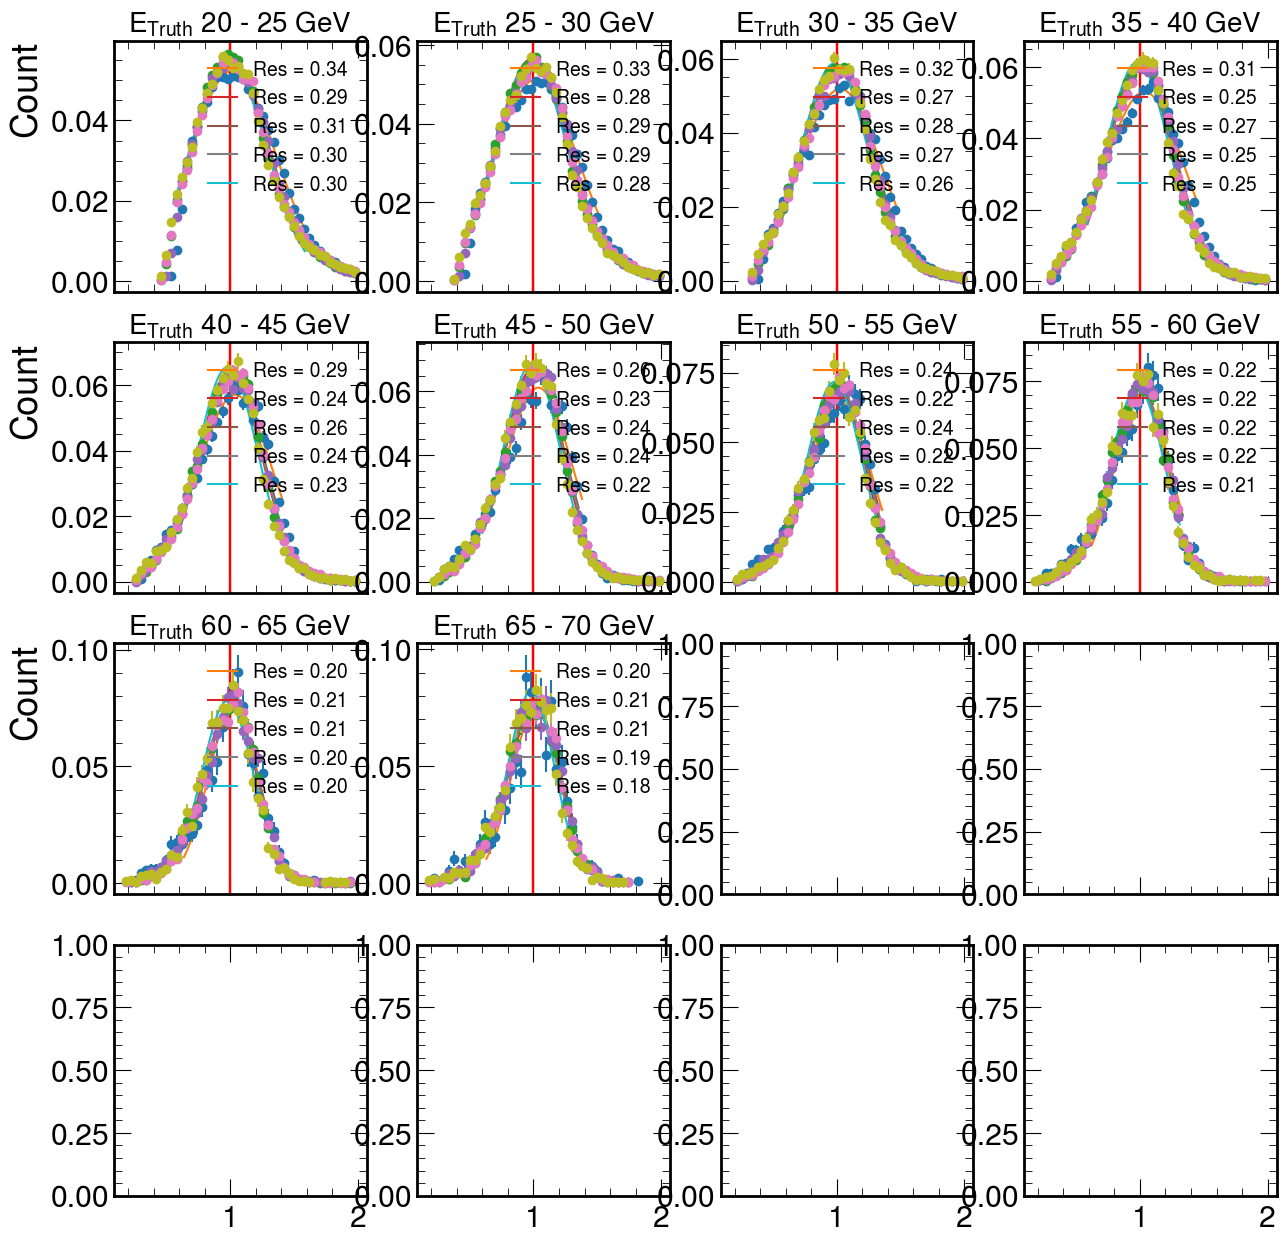

In [9]:
fig, axs=plt.subplots(4, 4, figsize=(15,15),sharex=True)
#fig.subplots_adjust(wspace=0.4, hspace=0)

def gauss(x, A, mu, sigma):
 
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
EtaCAvgR = []
EtaCAvgRErr = []

EtaCNumR = []
EtaCNumRErr = []

EtaRes = []
EtaResErr = []

EtaSigma = []
EtaSigmaErr = []

for eta in range(len(correctedGE)):

    CAvgR = []
    CAvgRErr = []

    CNumR = []
    CNumRErr = []

    Res = []
    ResErr = []

    Sigma = []
    SigmaErr = []

    GenSlice = []
    EBin = 0

    for i in range(lowerRange,upperRange,width):
 
        x = (EBin) // 4  
        y = (EBin) % 4
        EBin += 1
        plt.sca(axs[x][y])
        
        genEBin = (correctedGE[eta] > i) & (correctedGE[eta] < i+width)
    
        hist, bin_edges = np.histogram(JetRC[eta][genEBin],bins=50,range=(0,2))
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
    
        zerocut = (hist > 0)
        errs = np.sqrt(hist[zerocut]) / np.sum(hist[zerocut])
        hist = hist[zerocut] / np.sum(hist[zerocut])
        bins = bin_centres[zerocut]
    
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        plt.errorbar(np.array(bin_centres[zerocut]),np.array(hist),yerr=errs,fmt="o")

        minFit = bins[np.argmax(hist)] - 0.5
        maxFit = bins[np.argmax(hist)] + 0.5
        minFit = np.mean(JetRC[eta][genEBin]) - 1.5 * np.std(JetRC[eta][genEBin])
        maxFit = np.mean(JetRC[eta][genEBin]) + 1.5 * np.std(JetRC[eta][genEBin])
 
        fitCut = (bins > minFit) & (bins < maxFit)
    
       
        least_squares = LeastSquares(list(bin_centres[zerocut][fitCut]),list(hist[fitCut]),list(errs[fitCut]),gauss)
        m = Minuit(least_squares, A=max(hist), mu = 1.0, sigma = np.std(JetRC[eta][genEBin]))
        m.migrad()
        m.hesse()
        hist_fit = gauss(np.linspace(0,2,5000), m.values[0],m.values[1],m.values[2])
        fitPlotCut = (np.linspace(0,2,5000) > minFit) & (np.linspace(0,2,5000) < maxFit)
        hist_fit = gauss(np.linspace(0,2,5000)[fitPlotCut], m.values[0],m.values[1],m.values[2])
    
        plt.plot(np.linspace(0,2,5000)[fitPlotCut], hist_fit, label = "Res = %2.2f"%m.values[2])
        CNumR.append(np.mean(JetRC[eta][genEBin]))
        CNumRErr.append(np.std(JetRC[eta][genEBin]))
        plt.axvline(1,color='red')
        if (not math.isnan(m.values[1])):
            CAvgR.append(m.values[1])
            Res.append(np.abs(m.values[2])/m.values[1])

            ResErr.append(np.abs(m.errors[2])/ m.values[1])

            Sigma.append(np.abs(m.values[2]))

            SigmaErr.append(np.abs(m.errors[2]))

            CAvgRErr.append(m.errors[1])
        else:
            CAvgR.append(0)
            CAvgRErr.append(0)
        #plt.ylim(0,0.21)
        plt.legend(loc='upper right',fontsize=14)
        if(y == 0):
            plt.ylabel("Count")
        if(x == 7):
            plt.xlabel(r"Corrected $E_{Reco}$/$E_{Truth}$")
        plt.title(r'$E_{Truth}$ %2.0f - %2.0f GeV'%(i, i+(width)),fontsize=20)

    EtaCAvgR.append(CAvgR)
    EtaCAvgRErr.append(CAvgRErr)

    EtaCNumR.append(CNumR)
    EtaCNumRErr.append(CNumRErr)

    EtaRes.append(Res)
    EtaResErr.append(ResErr)

    EtaSigma.append(Sigma)
    EtaSigmaErr.append(SigmaErr)
#print(CAvgR)
#print(CAvgRErr)

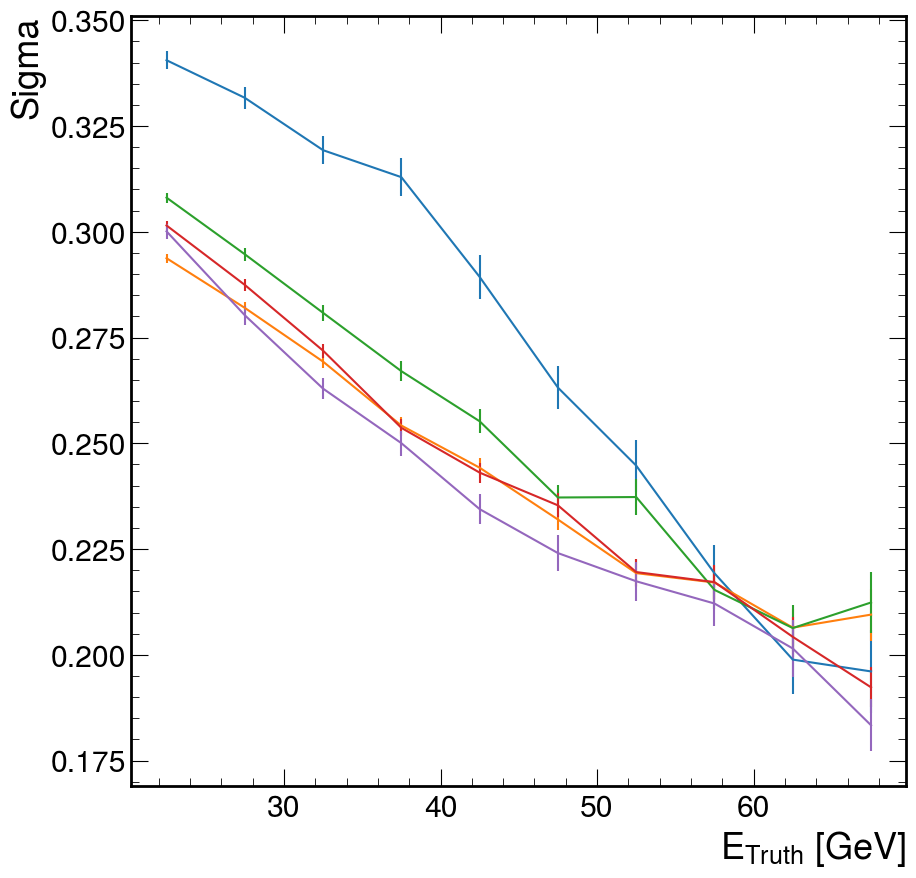

In [10]:
bin_centres = range(lowerRange,upperRange,width)
for i in range(len(correctedGE)):
    
    plt.errorbar(np.array(bin_centres)+(width/2),EtaSigma[i],yerr=EtaSigmaErr[i])

    plt.xlabel(r'$E_{Truth}$ [GeV]')
    plt.ylabel('Sigma')

#plt.ylim(0,0.3)
with open('Sigma_{}_C{}_2D.pickle'.format(generator,scale), 'wb') as f:
    pickle.dump((np.array(set(EtaSlice)), np.array(bin_centres)+(width/2), EtaSigma, EtaSigmaErr), f)

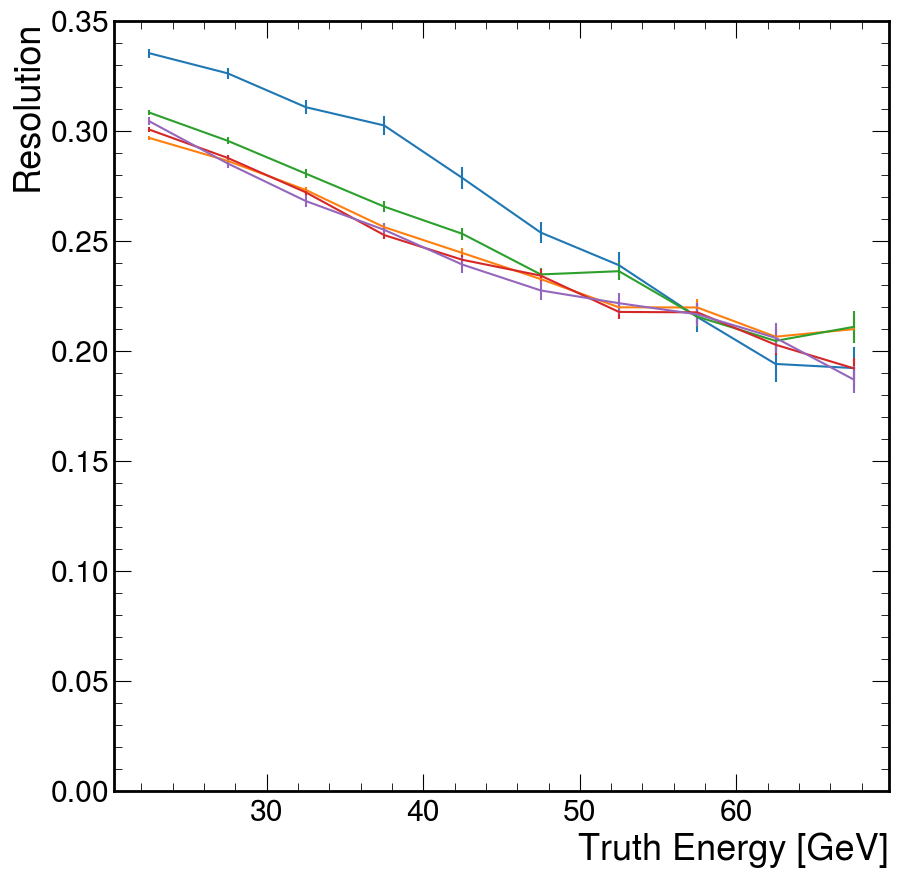

In [12]:
for i in range(len(correctedGE)):
    plt.errorbar(np.array(bin_centres)+(width/2),EtaRes[i],yerr=EtaResErr[i])
    plt.xlabel('Truth Energy [GeV]')
    plt.ylabel('Resolution')
    plt.ylim(0,0.35)
with open('Res_{}_C{}_2D.pickle'.format(generator,scale), 'wb') as f:    
    pickle.dump((np.array(set(EtaSlice)), np.array(bin_centres)+(width/2), EtaRes, EtaResErr), f)

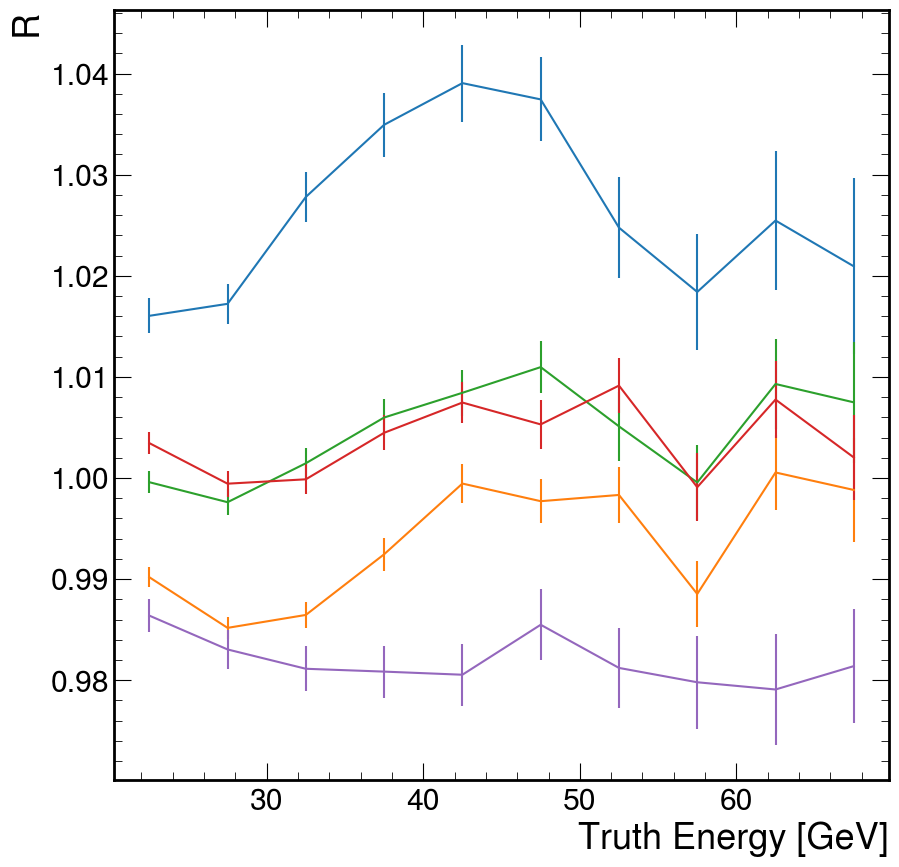

In [14]:

for i in range(len(correctedGE)):
    plt.errorbar(np.array(bin_centres)+(width/2),EtaCAvgR[i],yerr=EtaCAvgRErr[i])

    plt.xlabel('Truth Energy [GeV]')
    plt.ylabel('R')


#plt.ylim(0.9,1.0)
with open('R_{}_C{}_2D.pickle'.format(generator,scale), 'wb') as f:
    pickle.dump((np.array(set(EtaSlice)), np.array(bin_centres)+(width/2), EtaCAvgR, EtaCAvgRErr), f)

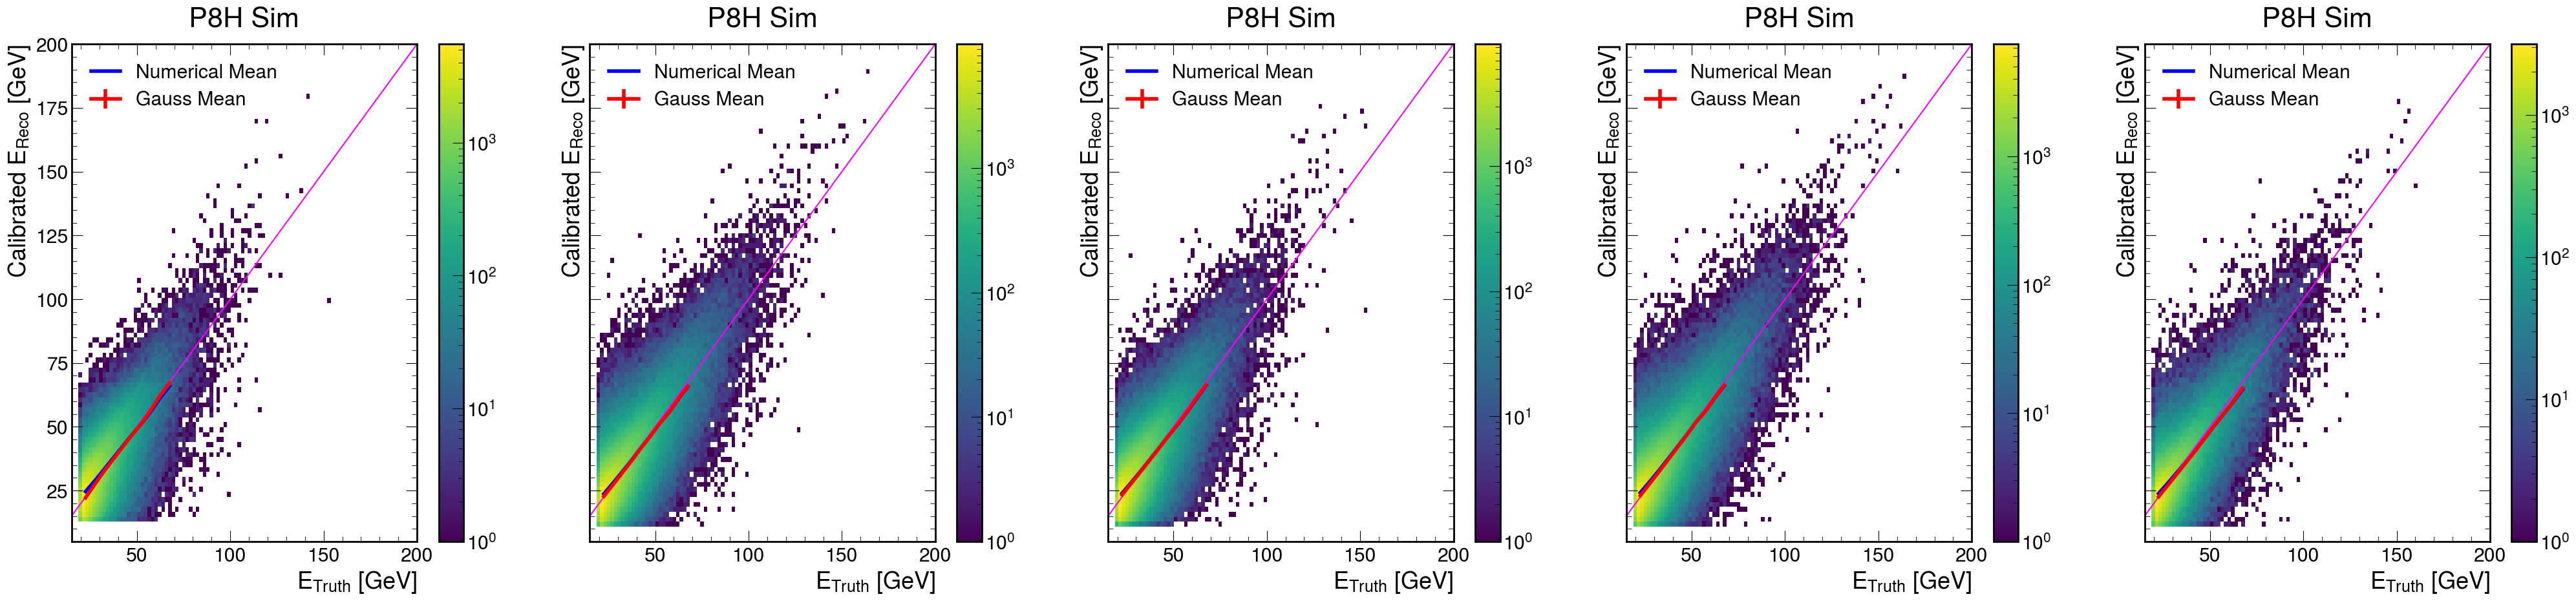

In [15]:
fig, axs=plt.subplots(1, 5, figsize=(50,10),sharex=True,sharey=True)
bin_centres = range(lowerRange,upperRange,width)

for i in range(len(correctedGE)):
    plt.sca(axs[i])
    plt.hist2d(np.array(correctedGE[i]),np.array(correctedReco[i]),bins=(100,100),range=([15,200],[5,200]),cmap='viridis',norm=abc.colors.LogNorm())
    cbar = plt.colorbar()
    plt.errorbar(np.array(bin_centres)+(width/2), EtaCAvgEReco[i], yerr=EtaCAvgERecoErr[i],color='red',label="Gauss Mean",linewidth=4)
    plt.plot(np.array(bin_centres)+(width/2), EtaCNumEReco[i], color='blue',label="Numerical Mean",linewidth=4)
    plt.plot(np.linspace(0,200,1000),np.linspace(0,200,1000),color='magenta')
    plt.legend(loc="upper left")
 
    plt.xlabel(r'$E_{Truth}$ [GeV]') 
    plt.ylabel(r'Calibrated $E_{Reco}$ [GeV]')
    plt.title("{} Sim".format(generator),pad = 20.0)


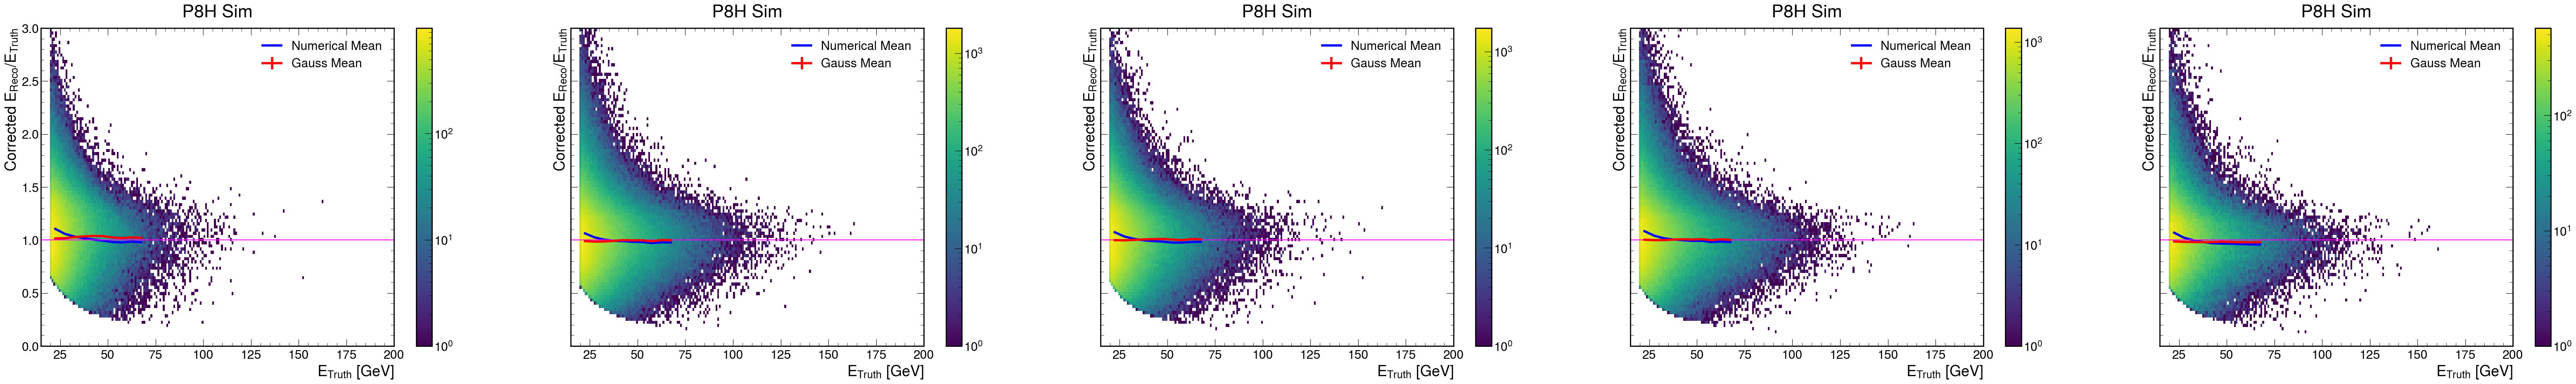

In [16]:
fig, axs=plt.subplots(1, 5, figsize=(80,10),sharex=True,sharey=True)
bin_centres = range(lowerRange,upperRange,width)

for i in range(len(correctedGE)):

    plt.sca(axs[i])
    plt.hist2d(np.array(correctedGE[i]),np.array(JetRC[i]),bins=(200,100),range=([15,200],[0,3]),cmap='viridis',norm=abc.colors.LogNorm())
    cbar = plt.colorbar()

    plt.errorbar(np.array(bin_centres)+(width/2), EtaCAvgR[i], yerr=EtaCAvgRErr[i],color='red',label="Gauss Mean",linewidth=4)
    plt.plot(np.array(bin_centres)+(width/2), EtaCNumR[i], color='blue',label="Numerical Mean",linewidth=4)
    plt.plot(np.linspace(0,200,1000),np.ones(1000),color='magenta')
    plt.legend(loc="upper right")
    plt.xlabel(r'$E_{Truth}$ [GeV]')
    plt.ylabel(r'Corrected $E_{Reco}$/$E_{Truth}$')
    plt.title("{} Sim".format(generator),pad = 20.0)
